In [2]:
# Library imports
import os
import re
import random
import logging
from tqdm import tqdm

# Libraries for data handling
import numpy as np
import pandas as pd

# Libraries for audio processing
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment, effects

In [42]:
root_dir = '../data/processed_audio' # the root directory of the dataset

emotion_dict = { # mapping of emotions to integers
    '01': 'neutral', 
    '02': 'happy',
    '03': 'suprised',
    '04': 'angry', 
    '05': 'sad',
}

intensity_dict = { # mapping of intensity to integers
    '01': 'normal',
    '02': 'strong',
}

repetition_dict = { # mapping of repetition to integers
    '01': 'first',
    '02': 'second',
    '03': 'third'
}

data = [] # list to store the data


for folder in tqdm(os.listdir(root_dir)):
    folder_path = os.path.join(root_dir, folder)
    
    # check if the folder is a directory
    if os.path.isdir(folder_path):
        # print(f"Processing folder: {folder}")
        
        for filename in os.listdir(folder_path):
            # print(f"Processing file: {filename}")
            
            if filename.endswith('.wav'):
                parts = filename.replace('.wav', '').split('-')
                
                actor_code = parts[0]
                emotion_code = parts[1]
                intensity_code = parts[2]
                repetition_code = parts[3]
                
                # print(f"Processing file: {filename}, actor: {actor}, emotion: {emotion}, intensity: {intensity}, repetition: {repetition}")
                
                actor_num = int(actor_code)
                gender = "male" if actor_num % 2 == 1 else "female"
                
                # Convert emotion code to integer
                emotion = emotion_dict.get(emotion_code, "unknown")
                intensity = intensity_dict.get(intensity_code, "unknown")
                repetition = repetition_dict.get(repetition_code, "unknown")
                
                data.append({
                    'emotion' : emotion,
                    'gender'  : gender,
                    # 'filename': filename,
                    'filepath': os.path.join(folder_path, filename),
                })    

100%|██████████| 11/11 [00:00<00:00, 5501.05it/s]


In [43]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_path = os.path.join(root_dir, 'metadata.csv')
df.to_csv(csv_path, index=False)
print(f"Metadata saved to {csv_path}")
# Display the first few rows of the DataFrame
print(df.head())

Metadata saved to ../data/processed_audio/metadata.csv
    emotion gender                                          filepath
0       sad   male  ../data/processed_audio/Actor_07/07-05-01-01.wav
1   neutral   male  ../data/processed_audio/Actor_07/07-01-02-02.wav
2     angry   male  ../data/processed_audio/Actor_07/07-04-02-01.wav
3     angry   male  ../data/processed_audio/Actor_07/07-04-01-03.wav
4  suprised   male  ../data/processed_audio/Actor_07/07-03-01-03.wav


In [46]:
# Display the distribution of emotions
emotion_counts = df['emotion'].value_counts()
print("Emotion distribution:")
print(emotion_counts)

Emotion distribution:
emotion
sad         60
neutral     60
angry       60
suprised    60
happy       60
Name: count, dtype: int64


In [47]:
def noise(data):
    noise_amp = 0.05 * np.random.uniform() * np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data


def pitch_shift(data, sample_rate):
    """
    Shift the pitch by n_steps
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                       sample_rate, n_steps=pitch_change, 
                                       bins_per_octave=bins_per_octave)
    return data

def speedNpitch(data):
    """
    speed and Pitch Tuning.
    """
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [48]:
# extract the feature using mfcc
extract_res = []
def mfcc_features(data):
    try:
        for index, row in data.iterrows():
            audio, sample_rate = librosa.load(row['filepath'])
            mfcc_def = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)

            augmentations = [
                lambda x: noise(x),
                lambda x: speedNpitch(x)
            ]

            extract_res.append({
                'emotion': row['emotion'],
                'filepath': row['filepath'],
                'features': mfcc_def
            })

            for aug in augmentations:
                augmented_data = aug(audio)
                mfccs = np.mean(librosa.feature.mfcc(y=augmented_data, sr=sample_rate, n_mfcc=40).T, axis=0)
                
                extract_res.append({
                    'emotion': row['emotion'],
                    'filepath': row['filepath'],
                    'features': mfccs
                })
        return extract_res
    except Exception as e:
        logging.error(f"Error {e} encountered while parsing file: {data['filepath']}")
        return None 

In [49]:
features = mfcc_features(df)
df_features = pd.DataFrame(features)

In [50]:
df_features.to_csv('../data/features.csv', index=False)
df_features.head()

,emotion,filepath,features
0,sad,../data/processed_audio/Actor_07/07-05-01-01.wav,"[-309.31964, 98.0551, 9.491294, 43.35269, -15...."
1,sad,../data/processed_audio/Actor_07/07-05-01-01.wav,"[-83.00465204823865, 24.471162299519754, 18.69..."
2,sad,../data/processed_audio/Actor_07/07-05-01-01.wav,"[-355.38943, 56.940826, 10.93719, 2.0664616, -..."
3,neutral,../data/processed_audio/Actor_07/07-01-02-02.wav,"[-349.14218, 69.58242, -13.074245, 34.373714, ..."
4,neutral,../data/processed_audio/Actor_07/07-01-02-02.wav,"[-94.9192211365623, 19.170560152216353, 9.2563..."


In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

label_encoder = LabelEncoder()

X = np.array(df_features['features'].tolist())
y = label_encoder.fit_transform(df_features['emotion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [52]:
columns = ['class_name', 'class_code']
class_names = pd.DataFrame(columns=columns)
class_names['class_name'] = label_encoder.classes_
class_names['class_code'] = label_encoder.transform(label_encoder.classes_)

class_names.to_csv('../saves/model/class_names.csv', index=False)

In [53]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (720, 40, 1)
X_test shape: (180, 40, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Define the model
model = Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

/home/reiaslite/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1024)           │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,333 (2.82 MB)

 Trainable params: 735,493 (2.81 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2490 - loss: 2.2392 - val_accuracy: 0.2278 - val_loss: 12.1411
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3550 - loss: 1.6638 - val_accuracy: 0.2444 - val_loss: 8.8269
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4012 - loss: 1.5663 - val_accuracy: 0.3056 - val_loss: 4.0820
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4441 - loss: 1.4521 - val_accuracy: 0.4500 - val_loss: 1.7709
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4502 - loss: 1.4273 - val_accuracy: 0.5222 - val_loss: 1.1963
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4224 - loss: 1.4173 - val_accuracy: 0.4944 - val_loss: 1.1953
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5344 - loss: 1.1678 - val_accuracy: 0.5222 - val_loss: 1.0975
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4839 - loss: 1.2528 - val_accuracy: 0.5167 - val_loss:

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7217 - loss: 0.5742 
Test Loss: 0.5803285241127014
Test Accuracy: 0.7388888597488403


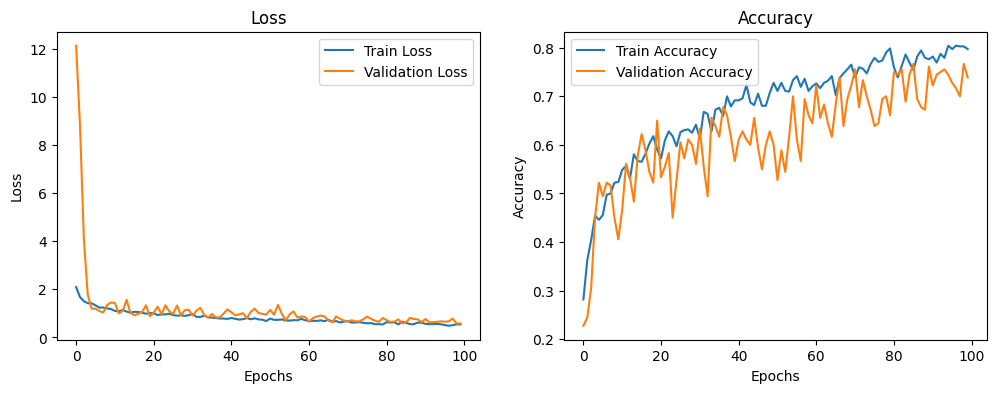

In [66]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [67]:
# Get predictions
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
test_accuracy = np.sum(y_pred_classes == y_test) / len(y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test Accuracy: 73.89%


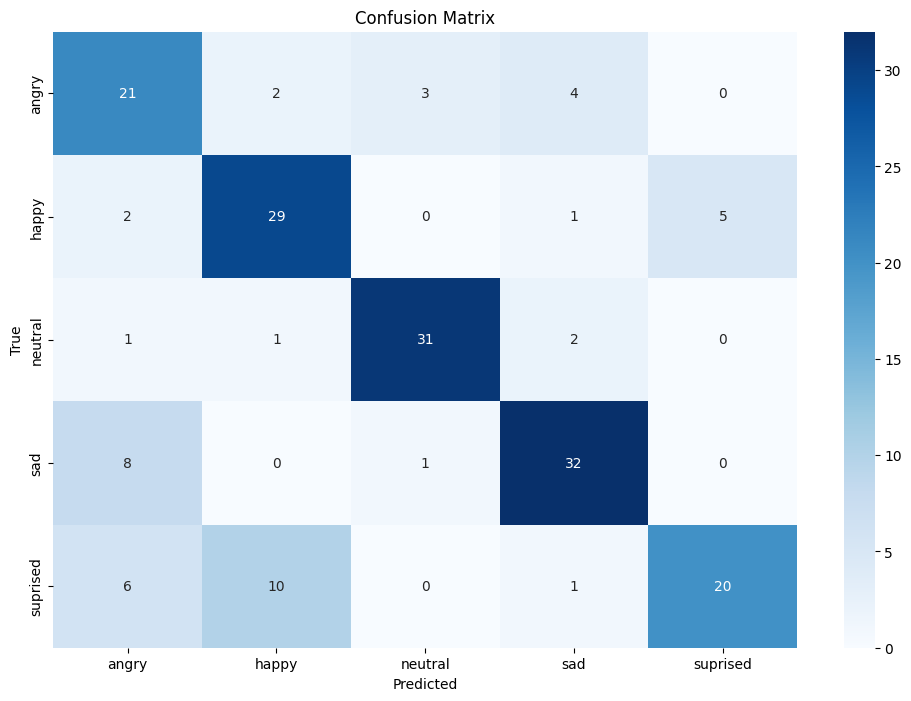

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()